In [1]:
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据
from torchvision import transforms as tfs

In [25]:
import cupy
def Random_affine(image,alpha_affine,random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)
    shape = image.shape
    shape_size = shape[:2]
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, 
                       [center_square[0]+square_size, center_square[1]-square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine,
                                       alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)

    image = cupy.asnumpy(image)
    image = cv2.warpAffine(image,M,shape_size[::-1],borderValue=-1)
    
    return image

In [47]:
# Elastic transform
def elastic_transformations(alpha, sigma, rng=np.random.RandomState(42), 
                            interpolation_order=1):
    """Returns a function to elastically transform multiple images."""
    # Good values for:
    #   alpha: 2000
    #   sigma: between 40 and 60
    def _elastic_transform_2D(images):
        """`images` is a numpy array of shape (K, M, N) of K images of size M*N."""
        # Take measurements
        image_shape = images[0].shape
        print(image_shape)
        # Make random fields
        dx = rng.uniform(-1, 1, image_shape) * alpha
        dy = rng.uniform(-1, 1, image_shape) * alpha
        print("dx,dy",dx.shape)
        print(dy.shape)
        # Smooth dx and dy
        sdx = gaussian_filter(dx, sigma=sigma, mode='reflect')
        sdy = gaussian_filter(dy, sigma=sigma, mode='reflect')
        print("sdx,sdy",sdx,sdy)
        # Make meshgrid
        x, y = np.meshgrid(np.arange(image_shape[1]), np.arange(image_shape[0]))
        print("x,y",x,"@@@@",y)
        # Distort meshgrid indices
        distorted_indices = (y + sdy).reshape(-1, 1), \
                            (x + sdx).reshape(-1, 1)
        print(distorted_indices)
        print(len(distorted_indices[0]))
        # Map cooordinates from image to distorted index set
        transformed_images = [map_coordinates(image, distorted_indices, mode='reflect',
                                              order=interpolation_order).reshape(image_shape)
                              for image in images]
        return transformed_images
    return _elastic_transform_2D

In [4]:
# 使用内置函数下载 mnist 数据集
train_set = mnist.MNIST('./data', train=True, download=True)
test_set = mnist.MNIST('./data', train=False, download=True)

In [5]:
'''def data_tf(x):
    im_aug = tfs.Compose([
    tfs.RandomAffine(10),
    tfs.ToTensor(),
    tfs.Normalize([0.5], [0.5])
    ])
    x = im_aug(x)
    return x'''

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x
    
    return x
train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) # 重新载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)

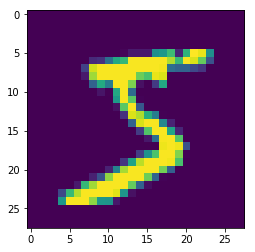

In [14]:
a_data,a_label=train_set[0]
a_data=np.reshape(a_data,(28,28))
plt.imshow(a_data)

torch.Size([1, 28, 28])
torch.Size([28, 28])
dx,dy (28, 28)
(28, 28)
sdx,sdy [[-2.65302251e+00 -2.58683579e+00 -2.46068964e+00 -2.29089641e+00
  -2.10904808e+00 -1.96573268e+00 -1.91835372e+00 -2.02297820e+00
  -2.31208628e+00 -2.78168386e+00 -3.38582803e+00 -4.04153473e+00
  -4.64830250e+00 -5.10840380e+00 -5.34630843e+00 -5.32395060e+00
  -5.04321917e+00 -4.53902701e+00 -3.87033197e+00 -3.10542485e+00
  -2.31550727e+00 -1.56674456e+00 -9.13356286e-01 -3.94316041e-01
  -2.23388406e-02  2.12956423e-01  3.40141808e-01  3.92446878e-01]
 [-2.34966380e+00 -2.30069757e+00 -2.20739963e+00 -2.08294154e+00
  -1.95447537e+00 -1.86684430e+00 -1.87124390e+00 -2.01730297e+00
  -2.33198012e+00 -2.80735878e+00 -3.39615230e+00 -4.01705108e+00
  -4.57437414e+00 -4.97750494e+00 -5.15916242e+00 -5.08881835e+00
  -4.77378381e+00 -4.25156921e+00 -3.58095597e+00 -2.82841538e+00
  -2.06242729e+00 -1.34649332e+00 -7.32228625e-01 -2.55740333e-01
   7.38310438e-02  2.71246983e-01  3.69716653e-01  4.06500546e-0

  -4.17112363e+00 -4.38820602e+00 -4.52071243e+00 -4.58272539e+00]] [[-3.86390447 -4.04044597 -4.35332929 -4.73301434 -5.09384319 -5.35720249
  -5.46626539 -5.40063036 -5.17333454 -4.82774007 -4.41989068 -4.0100786
  -3.64302829 -3.34141524 -3.09987479 -2.88182978 -2.62613144 -2.26313543
  -1.73051401 -0.99006484 -0.046754    1.05227219  2.2238818   3.3698326
   4.39183398  5.21387621  5.78510871  6.07659906]
 [-4.11508137 -4.27986922 -4.5700078  -4.91772644 -5.2405056  -5.46401373
  -5.53633288 -5.44117333 -5.19380194 -4.83693654 -4.42300438 -4.00672743
  -3.6273933  -3.30422161 -3.03204103 -2.77841079 -2.48906487 -2.1017847
  -1.55976412 -0.82671851  0.09465183  1.16267004  2.30096381  3.41713854
   4.41652491  5.22395239  5.78723207  6.07545542]
 [-4.54483902 -4.68795045 -4.93623281 -5.22530001 -5.47848292 -5.62924937
  -5.63448344 -5.48510796 -5.20015199 -4.82093038 -4.39322367 -3.96175071
  -3.55624035 -3.1900936  -2.85902013 -2.538616   -2.18754858 -1.75736021
  -1.20133525 -0.48

   1.03110849  0.84413688  0.70886189  0.63825683]]
x,y [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 1

       [22.41727461]]))
784
(1, 28, 28)


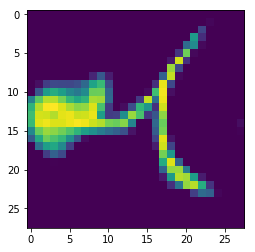

In [48]:
a_data, a_label = train_set[2]
a_data=np.reshape(a_data,(1,28,28))
print(a_data.shape)
k=elastic_transformations(60,4)
a_data=k(a_data)
#a_data=elastic_transform(a_data,34,4)
a_data=np.array(a_data, dtype='float32')
print(a_data.shape)

a_data=np.reshape(a_data,(28,28))


plt.imshow(a_data)

(28, 28)


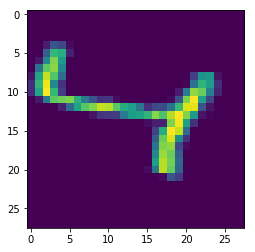

In [30]:
a_data, a_label = train_set[2]
a_data=np.reshape(a_data,(28,28))
a_data=Random_affine(a_data,4)
print(a_data.shape)

plt.imshow(a_data)

In [22]:
from torch.utils.data import DataLoader
# 使用 pytorch 自带的 DataLoader 定义一个数据迭代器
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)
print(train_data.dataset)
print(test_data.dataset)
a, a_label = next(iter(train_data))
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: <function data_tf at 0x000000001A428AE8>
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: <function data_tf at 0x000000001A428AE8>
torch.Size([64, 784])
torch.Size([64])


torch.Size([784])


IndexError: tuple index out of range

In [47]:
TwoLayerMlp = nn.Sequential(
    nn.Linear(784, 800),
    nn.Sigmoid(),
    nn.Linear(800, 10)
)

In [48]:
import torch.optim as optim
from torch.optim import lr_scheduler
# 定义 loss 函数
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(TwoLayerMlp.parameters(), 0.05) # 使用随机梯度下降，学习率 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.3)

if torch.cuda.is_available():
        TwoLayerMlp = TwoLayerMlp.cuda()
'''
plt.figure()
x = list(range(100))
y = []
for epoch in range(100):
    scheduler.step()
    lr = scheduler.get_lr()
    print(epoch, scheduler.get_lr()[0])
    y.append(scheduler.get_lr()[0])
'''

'\nplt.figure()\nx = list(range(100))\ny = []\nfor epoch in range(100):\n    scheduler.step()\n    lr = scheduler.get_lr()\n    print(epoch, scheduler.get_lr()[0])\n    y.append(scheduler.get_lr()[0])\n'

In [49]:
# TwoLayerMlp训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(200):
    scheduler.step()
    train_loss = 0.0
    train_acc = 0.0
    TwoLayerMlp.train()
    for im, label in train_data:
        if torch.cuda.is_available():
                im = Variable(im.cuda())  # (bs, 3, h, w)
                label = Variable(label.cuda())  # (bs, h, w)
        else:
                im = Variable(im)
                label = Variable(label)

        # 前向传播
        out = TwoLayerMlp(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data
        # 计算分类的准确率
        _, pred = out.max(1)
        #print("out",out.max(1))
        #print("pred",pred)    
        num_correct = (pred == label).sum().data
        acc = float(num_correct) / float(im.shape[0])
        train_acc += acc
        
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    # 在测试集上检验效果
    eval_loss = 0.0
    eval_acc = 0.0
    TwoLayerMlp.eval() # 将模型改为预测模式
    for im, label in test_data:
        if torch.cuda.is_available():
                im = Variable(im.cuda())  # (bs, 3, h, w)
                label = Variable(label.cuda())  # (bs, h, w)
        else:
                im = Variable(im)
                label = Variable(label)
        out = TwoLayerMlp(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.data
        # 记录准确率
        _, pred = out.max(1)
       
        num_correct = (pred == label).sum().data
        acc = float(num_correct) / float(im.shape[0])
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

D:\anaconda\lib\site-packages\torch\optim\lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch: 0, Train Loss: 0.750255, Train Acc: 0.791378, Eval Loss: 0.392593, Eval Acc: 0.889339
epoch: 1, Train Loss: 0.365668, Train Acc: 0.893507, Eval Loss: 0.330872, Eval Acc: 0.900712
epoch: 2, Train Loss: 0.327316, Train Acc: 0.904201, Eval Loss: 0.320164, Eval Acc: 0.901404
epoch: 3, Train Loss: 0.307746, Train Acc: 0.910081, Eval Loss: 0.294891, Eval Acc: 0.916337
epoch: 4, Train Loss: 0.292814, Train Acc: 0.914662, Eval Loss: 0.278109, Eval Acc: 0.918018
epoch: 5, Train Loss: 0.280689, Train Acc: 0.919093, Eval Loss: 0.265711, Eval Acc: 0.923853
epoch: 6, Train Loss: 0.268354, Train Acc: 0.922958, Eval Loss: 0.268822, Eval Acc: 0.919699
epoch: 7, Train Loss: 0.256126, Train Acc: 0.926173, Eval Loss: 0.249287, Eval Acc: 0.930578
epoch: 8, Train Loss: 0.243400, Train Acc: 0.930154, Eval Loss: 0.232398, Eval Acc: 0.933445
epoch: 9, Train Loss: 0.231522, Train Acc: 0.934168, Eval Loss: 0.228132, Eval Acc: 0.937994
epoch: 10, Train Loss: 0.220195, Train Acc: 0.937617, Eval Loss: 0.216

epoch: 173, Train Loss: 0.014411, Train Acc: 0.998467, Eval Loss: 0.058686, Eval Acc: 0.981112
epoch: 174, Train Loss: 0.014354, Train Acc: 0.998467, Eval Loss: 0.058892, Eval Acc: 0.980518
epoch: 175, Train Loss: 0.014298, Train Acc: 0.998467, Eval Loss: 0.058316, Eval Acc: 0.981309
epoch: 176, Train Loss: 0.014233, Train Acc: 0.998467, Eval Loss: 0.058567, Eval Acc: 0.980914
epoch: 177, Train Loss: 0.014191, Train Acc: 0.998368, Eval Loss: 0.058327, Eval Acc: 0.981210
epoch: 178, Train Loss: 0.014143, Train Acc: 0.998517, Eval Loss: 0.058311, Eval Acc: 0.981112
epoch: 179, Train Loss: 0.014071, Train Acc: 0.998418, Eval Loss: 0.058128, Eval Acc: 0.980914
epoch: 180, Train Loss: 0.014003, Train Acc: 0.998451, Eval Loss: 0.058195, Eval Acc: 0.980815
epoch: 181, Train Loss: 0.013926, Train Acc: 0.998534, Eval Loss: 0.058175, Eval Acc: 0.980716
epoch: 182, Train Loss: 0.013870, Train Acc: 0.998534, Eval Loss: 0.058229, Eval Acc: 0.981013
epoch: 183, Train Loss: 0.013801, Train Acc: 0.998